In [1]:

import substation_analysis_functions
from substation_analysis_functions import *
from imp import reload
reload(substation_analysis_functions)
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import geopandas as gpd
from shapely.geometry import Point
import pyproj

from sklearn.cluster import KMeans
import math
from shapely.ops import transform
from shapely.ops import unary_union
from shapely.ops import nearest_points


/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Read data

In [2]:
# consumer_data = pd.read_csv('../consumer_data_counts_by_substation.csv')
# consumer_data.set_index('substation', inplace = True)
# consumer_data.index = consumer_data.index.str.lower()
# consumer_data['total_consumers'] = consumer_data.sum(axis = 1)

folder_path = "../Substation Busbar Data/"
dataframes, substation_IDs = substation_analysis_functions.read_substation_data(folder_path)
dataframes = substation_analysis_functions.handle_missing_vals(dataframes, threshold = 0.5)
for substation, dataframe in dataframes.items():
    dataframes[substation]['Date'] = dataframes[substation]['Datetime'].dt.date
    dataframes[substation]['Hour'] = dataframes[substation]['Datetime'].dt.hour
    dataframes[substation] = substation_analysis_functions.detect_bad_power_vals(dataframe,active_upper_threshold = 700, active_lower_threshold = 0, reactive_upper_threshold = 250, reactive_lower_threshold = -100) 


############  Read in raw consumer locs data ############

consumer_locs = pd.read_csv('../Dancing_types.csv')
consumer_locs['Land Uses'] = consumer_locs['LANDUSEDES']

# Define the projection of the input coordinates (OSGB36)
input_proj = pyproj.Proj(init='epsg:27700')

# Define the projection of the output coordinates (WGS84)
output_proj = pyproj.Proj(init='epsg:4326')

# Transform the coordinates
consumer_locs['Longitude'], consumer_locs['Latitude'] = pyproj.transform(input_proj, output_proj, consumer_locs['X'], consumer_locs['Y'])
consumer_locs = consumer_locs[['Longitude', 'Latitude', 'Land Uses']]

# Create a new 'geometry' column containing Point objects
geometry = [Point(xy) for xy in zip(consumer_locs['Longitude'], consumer_locs['Latitude'])]
consumer_locs = gpd.GeoDataFrame(consumer_locs, geometry=geometry, crs='EPSG:4326')




# Read in LSOA - location data
lsoa_data = gpd.read_file('lsoa_id/lsoa_data_vac1.shp')

# Read in substation - location data
substation_location_data = pd.read_csv('../substation_descriptive_data.csv')
substation_location_data['Longitude'] = -1 * substation_location_data['Longitude']



# Create a new 'geometry' column containing Point objects
geometry = [Point(xy) for xy in zip(substation_location_data['Longitude'], substation_location_data['Latitude'])]
substation_location_data = gpd.GeoDataFrame(substation_location_data, geometry=geometry, crs='EPSG:4326')


# Perform a spatial join between the two dataframes
joined_data = gpd.sjoin(substation_location_data, lsoa_data, op='within')



Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000

/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (9,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-ch

To-DO: 
1. Reassign consumers to subsattions <font color = 'orange'> In progress </font> 
2. Methodology Flow Chart
 

Filter out consumers who are outside of 500m away from any substation

In [3]:
# Define the projection to use (e.g., UTM zone)
utm_zone = "30"
project = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:326{utm_zone}")

# Project the points to the UTM zone
projected_points = substation_location_data.geometry.apply(lambda p: transform(project.transform, p))

# Calculate a buffer of 500m around each point in the projected coordinate system
substation_buffer = projected_points.buffer(500)

# Define the inverse projection to use (from UTM to WGS84)
inv_project = pyproj.Transformer.from_crs(f"EPSG:326{utm_zone}", "EPSG:4326")

# Transform the projected buffer back to EPSG:4326
buffer_latlon = substation_buffer.geometry.apply(lambda p: transform(inv_project.transform, p))

# convert substation_buffer to a GeoDataFrame with a 'geometry' column
substation_buffer_gdf = gpd.GeoDataFrame(geometry=buffer_latlon)

substation_buffer_gdf_dissolved = substation_buffer_gdf.dissolve()

# merge consumers within buffer distance of substations
consumers_within_substation_buffer = gpd.sjoin(consumer_locs, substation_buffer_gdf_dissolved, op='within')
consumers_within_substation_buffer.drop(columns = ['index_right'], inplace = True)


/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_90510/1554258598.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  substation_buffer = projected_points.buffer(500)
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Plot

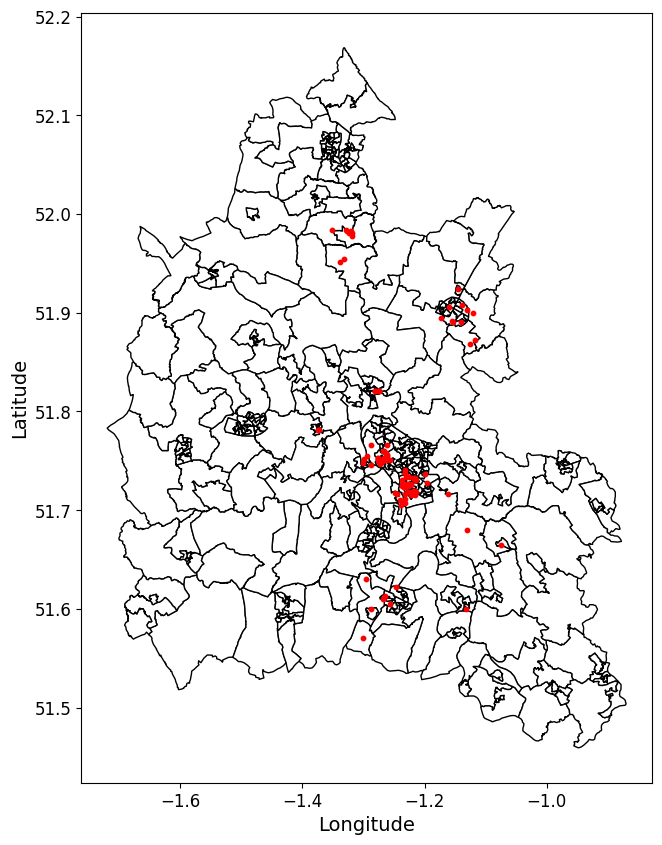

In [255]:
lsoa_data.plot(color = 'white', edgecolor = 'black', figsize = (8,10))
#consumers_within_substation_buffer.plot(ax = plt.gca(), marker = 'x', color = 'blue', markersize = 10)
joined_data.plot(ax = plt.gca(), marker = 'o', color = 'red', markersize = 10, label = 'Substations')
# plt.legend()
plt.xlabel("Longitude", fontsize = 14)
plt.ylabel("Latitude", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("figures/report/substations_in_oxfordshire.png")
plt.show()

### Assign each consumer to a substation by finding its nearest substation

In [80]:
consumers_geodf

Longitude_left  Latitude_left     Land Uses  \
52           -1.148012      51.923586   Residential   
453          -1.145494      51.925213          Land   
8679         -1.145767      51.923093  Parent Shell   
8681         -1.145782      51.923093  Parent Shell   
8938         -1.146074      51.921504  Parent Shell   
...                ...            ...           ...   
385775       -1.272942      51.747658    Commercial   
385777       -1.273530      51.746205    Commercial   
385779       -1.272791      51.746228    Commercial   
462700       -1.273944      51.747485    Commercial   
462729       -1.273944      51.747485    Commercial   

                         geometry  index_right  Substation Number  \
52      POINT (-1.14801 51.92359)           79         4605010210   
453     POINT (-1.14549 51.92521)           79         4605010210   
8679    POINT (-1.14577 51.92309)           79         4605010210   
8681    POINT (-1.14578 51.92309)           79         4605010210   
8938    POINT (-1.14607 51.92150)           79         4605010210   
...                           ...          ...                ...   
385775  POINT (-1.27294 51.74766)           11         4626004180   
385777  POINT (-1.27353 51.74621)           11         4626004180   
385779  POINT (-1.27279 51.74623)           11         4626004180   
462700  POINT (-1.27394 51.74748)           11         4626004180   
462729  POINT (-1.27394 51.74748)           11         4626004180   

         Substation Site Substation State  Latitude_right  Longitude_right  \
52      Springfield Road        INSTALLED       51.923586        -1.145861   
453     Springfield Road        INSTALLED       51.923586        -1.145861   
8679    Springfield Road        INSTALLED       51.923586        -1.145861   
8681    Springfield Road        INSTALLED       51.923586        -1.145861   
8938    Springfield Road        INSTALLED       51.923586        -1.145861   
...                  ...              ...             ...              ...   
385775  osney mead pylon        INSTALLED       51.746691        -1.272336   
385777  osney mead pylon        INSTALLED       51.746691        -1.272336   
385779  osney mead pylon        INSTALLED       51.746691        -1.272336   
462700  osney mead pylon        INSTALLED       51.746691        -1.272336   
462729  osney mead pylon        INSTALLED       51.746691        -1.272336   

             Region Operational Area    Device Serial  \
52      STH - South    RW - Ridgeway  SS7400005105221   
453     STH - South    RW - Ridgeway  SS7400005105221   
8679    STH - South    RW - Ridgeway  SS7400005105221   
8681    STH - South    RW - Ridgeway  SS7400005105221   
8938    STH - South    RW - Ridgeway  SS7400005105221   
...             ...              ...              ...   
385775  STH - South    RW - Ridgeway  SS7400009305221   
385777  STH - South    RW - Ridgeway  SS7400009305221   
385779  STH - South    RW - Ridgeway  SS7400009305221   
462700  STH - South    RW - Ridgeway  SS7400009305221   
462729  STH - South    RW - Ridgeway  SS7400009305221   

       Last Communication (Dublin. Edinburgh. Lisbon. London)  \
52                                    27/05/2022 17:14:11       
453                                   27/05/2022 17:14:11       
8679                                  27/05/2022 17:14:11       
8681                                  27/05/2022 17:14:11       
8938                                  27/05/2022 17:14:11       
...                                                   ...       
385775                                01/03/2023 14:41:09       
385777                                01/03/2023 14:41:09       
385779                                01/03/2023 14:41:09       
462700                                01/03/2023 14:41:09       
462729                                01/03/2023 14:41:09       

                                                    Modes  
52      NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI.

/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


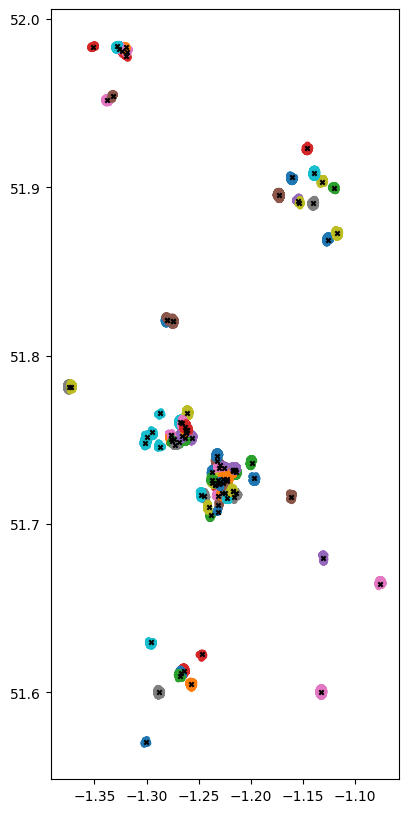

In [81]:
consumers_geodf=gpd.sjoin_nearest(consumers_within_substation_buffer, substation_location_data, how = 'inner')

# checking that the consumers ended up with the right substations
consumers_geodf.plot(column = 'Substation Site', markersize = 15, figsize = (10,10))
substation_location_data.plot(ax = plt.gca(), marker = 'x', color = 'black', edgecolor = 'white', markersize = 10)
plt.show()



In [82]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    print('Finding nearest points')
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    print('Getting corresponding values from other DF')
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    
    
    nearest_value = nearest_data[value_column].values[0]
    print('Nearest value', nearest_value)
    
    return nearest_value

In [83]:
# convert consumers_within_substation_buffer to a GeoDataFrame with a 'geometry' column
consumers_geodf = gpd.GeoDataFrame(consumers_within_substation_buffer, geometry = consumers_within_substation_buffer.geometry, crs = 'EPSG:4326')

consumers_geodf['Substation'] = consumers_geodf.apply(get_nearest_values, other_gdf = substation_location_data, value_column = 'Substation Site', axis = 1)

# create total consumers per substation DF
total_consumers_df = consumers_geodf.groupby(['Substation']).size().reset_index(name = 'total_consumers')
total_consumers_df.set_index('Substation', inplace = True)
total_consumers_df

# create consumer breakdown per substation DF
consumer_breakdown_df  = consumers_geodf.groupby(['Substation', 'Land Uses']).size().unstack().fillna(0)
consumer_breakdown_df['total_consumers'] = consumer_breakdown_df.sum(axis = 1)
consumer_breakdown_df

Finding nearest points
Getting corresponding values from other DF
Nearest value Springfield Road
Finding nearest points
Getting corresponding values from other DF
Nearest value Springfield Road
Finding nearest points
Getting corresponding values from other DF
Nearest value medawar centre
Finding nearest points
Getting corresponding values from other DF
Nearest value medawar centre
Finding nearest points
Getting corresponding values from other DF
Nearest value brookhampton
Finding nearest points
Getting corresponding values from other DF
Nearest value Thames view Road no2
Finding nearest points
Getting corresponding values from other DF
Nearest value brookhampton
Finding nearest points
Getting corresponding values from other DF
Nearest value Chilton Garden Centre
Finding nearest points
Getting corresponding values from other DF
Nearest value Chilton Garden Centre
Finding nearest points
Getting corresponding values from other DF
Nearest value texas homecare
Finding nearest points
Getting

TypeError: issubclass() arg 1 must be a class

In [109]:
consumers_geodf['Substation'].unique()
consumers_geodf[consumers_geodf['Substation'] == 'units 13/14 Oxford science pk'].groupby('Land Uses').count()

Longitude  Latitude  geometry  Substation
Land Uses                                              
Commercial           57        57        57          57
Land                  4         4         4           4
Parent Shell         15        15        15          15
Residential         200       200       200         200

In [104]:
consumers_geodf.groupby(['Substation', 'Land Uses']).count().loc['osney mead pylon']

Longitude  Latitude  geometry
Land Uses                                  
Commercial           87        87        87
Features              6         6         6
Land                  8         8         8
Parent Shell          6         6         6

electric heating is trivial additional load
UK electricity demand in residential especially areas is driven by lighting needs
so split the data from daylight savings to daylight savings...

find substations that switch from week to weekend.

why we want to use
you could have someone go through feeders one by one and find out who is connectd to what substation

or you could use a numeric method to get an estimatino of the mix of consumer, and therefore from that, an idea of the possibility of success of flexibility requests in particular areas/particular substations. 

idea is it saves a lot of time manually going through data

need definitely number of consumers for each substations

need consumer mix for representative subsample to validate model

if we know distribution: whcih is n domestic, and what the types of other buildings are
SIC codes - standard industry classifer codes... or land use...
David has dataset of 12.5k non domestic businesses with SIC codes. IF a business is x type of business, on average it has load profile that looks like ___ (get from data)

if you know how many non-domestics there are out of total population of consumers, you could subtract non-domestics and see what the resulting shape is.. 

In [ ]:
# checking that the consumers ended up with the right substations
consumers_geodf.plot(column = 'Substation', markersize = 15, figsize = (10,10))
substation_location_data.plot(ax = plt.gca(), marker = 'x', color = 'black', edgecolor = 'white', markersize = 10)
plt.show()

# create total consumers per substation DF
total_consumers_df = consumers_geodf.groupby(['Substation']).size().reset_index(name = 'total_consumers')
total_consumers_df.set_index('Substation', inplace = True)
total_consumers_df

# create consumer breakdown per substation DF
consumer_breakdown_df  = consumers_geodf.groupby(['Substation', 'Land Uses']).size().unstack().fillna(0)
consumer_breakdown_df['total_consumers'] = consumer_breakdown_df.sum(axis = 1)
consumer_breakdown_df

In [ ]:
consumer_breakdown_df


## ADMD analysis

In [ ]:
# Read in LSOA - EV count data
ev_numbers_by_lsoa = pd.read_excel('EV numbers.xlsx')
#ev_numbers_by_lsoa.head(5)

# merge joined_data and ev_numbers_by_lsoa on joined_data['lsoa11cd'] and ev_numbers_by_lsoa['lsoa']
ev_count_by_substation = pd.merge(joined_data, ev_numbers_by_lsoa, left_on = 'lsoa11cd', right_on = 'lsoa')
ev_count_by_substation.set_index('Substation Number', inplace = True)
ev_count_by_substation

Monthly ADMD

In [ ]:
####### MONTHLY ADMD #######

###### Get substation monthly active power ######
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
days_in_month_df = pd.DataFrame(columns = ['Month', 'total_available_monthly_hours'])
days_in_month_df['Month'] = np.arange(1,13)
days_in_month_df['total_available_monthly_hours'] = [24 * days for days in days_in_month]

# Get total Active Power for each substation for each month (.groupby('Month').sum('Active Power [kW]'))
substation_monthly_active_powers = pd.DataFrame(index = dataframes.keys(), columns = np.arange(1,13))
for substation in dataframes:
    print(substation)
    # Add month column to dataframe
    dataframes[substation]['Month'] = dataframes[substation]['Datetime'].dt.month
    
    # Group data by month
    grouped_data = dataframes[substation].groupby('Month')
    
    ### Get total Active Power for each substation for each month
    monthly_powers = grouped_data['Active Power [kW]'].max() 
    
    # Create a new dataframe with the monthly active power data and the number of hours of data for each month
    monthly_powers_and_hour_count = pd.concat([monthly_powers, grouped_data.count()['Hour']], axis = 1)
    
    # identify the total number of hours that should appear in each month that this substation has data on if the data was perfectly complete
    monthly_powers_and_hour_count = pd.merge(monthly_powers_and_hour_count, days_in_month_df, on = 'Month')
    monthly_powers_and_hour_count.set_index('Month', inplace = True)

    # Replace monthly active power values with nan's for months that are missing at least two days of data
    monthly_powers_and_hour_count['Active Power [kW]'] = np.where(monthly_powers_and_hour_count['Hour'] > monthly_powers_and_hour_count['total_available_monthly_hours'] - 48, grouped_data.max()['Active Power [kW]'], np.nan)
   
    # Create a new array of length 12 filled with nan's to host the monthly active power data
    monthly_active_power_clean = np.full((1, 12), np.nan)
    
    # Replace nan's with the monthly active power data corresponding to the months with data
    months_with_data = monthly_powers_and_hour_count.index.values
    
    monthly_active_power_clean[:, months_with_data-1] = monthly_powers_and_hour_count['Active Power [kW]'].values.reshape(1, -1)
       
    
    # Add monthly_powers to substation_monthly_active_powers dataframe
    substation_monthly_active_powers.loc[substation] = monthly_active_power_clean
  
  
  
  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####

# Merge substation_monthly_active_powers with substation_IDs to get numbers for each substation
substation_monthly_active_powers_with_ID = pd.merge(substation_monthly_active_powers, substation_IDs, left_index = True, right_on = 'Substation').set_index("ID")

# Merge substation_monthly_active_powers with ev_count_by_substation to get numbers for each substation, merge on the indeces for the two dataframes
substation_monthly_active_powers_and_ev_counts = pd.merge(substation_monthly_active_powers_with_ID, ev_count_by_substation, left_index = True, right_index = True)

substation_monthly_active_powers_and_ev_counts.drop_duplicates(inplace = True, keep = 'first')



# Take those columns out and put them in the final dataframe for calculating ADMD
admd_df = pd.concat([substation_monthly_active_powers_and_ev_counts.iloc[:,0:13], substation_monthly_active_powers_and_ev_counts[['lsoa', 'Substation Site', '2025']]], axis = 1)
admd_df.set_index('Substation Site', inplace = True)

# Add the consumer count for each substation by joining admd_df and consumer_data on admd_df.index and consumer_data.index
admd_df = pd.merge(admd_df, consumer_data, left_index = True, right_index = True)

# Drop duplicated indeces
admd_df = admd_df[~admd_df.index.duplicated(keep='first')]

# Create a column that identifies how many times the LSOA in that row appears in the dataframe
admd_df['lsoa_count'] = admd_df.groupby('lsoa')['lsoa'].transform('count')

# Create a column that identifies how many consumers are in each LSOA
admd_df['consumers_wihin_lsoa'] = admd_df.groupby('lsoa')['total_consumers'].transform('sum')

# Create a column that identifies the proportion of consumers each substation has in its LSOA
admd_df['substation_population_weight_within_lsoa'] = admd_df['total_consumers'] / admd_df['consumers_wihin_lsoa']

# Split EVs among substations for the LSOA with multiple substations
admd_df['ev_count'] = admd_df['2025'] * admd_df['substation_population_weight_within_lsoa']

# divide the monthly active power sum columns (columns 1 thru 12) by the column 'total_consumers' to get the ADMD for each month for each substation
admd_df.iloc[:,0:12] = admd_df.iloc[:,0:12].div(admd_df['total_consumers'], axis = 0)
admd = pd.concat([admd_df.iloc[:,0:12], admd_df['ev_count']], axis = 1)
print(len(admd), "substations made it all the way through to the final dataset")


# Plotting: Compare ADMD in months 1 through 12 with ev_count (each color is a month)
for i in range(1,13):
    plt.scatter(y = admd[i], x = admd['ev_count'])
plt.ylabel('ADMD (max of monthly active power / total consumers)')
plt.xlabel('EV Count (num EVs in LSOA / num substations in LSOA)')

plt.show()

Yearly ADMD

In [ ]:
####### YEARLY ADMD #######
# Get total Active Power for each substation for each month (.groupby('Month').sum('Active Power [kW]'))
substation_yearly_max_power = pd.DataFrame(index = dataframes.keys(), columns = ['Maximum Active Power [kW]'])
for substation in dataframes:
    max_power = dataframes[substation]['Active Power [kW]'].max()
   # print(max_power)
     # Add monthly_powers to substation_monthly_active_powers dataframe
    substation_yearly_max_power.loc[substation] = max_power
   
substation_yearly_max_power_with_ID = pd.merge(substation_yearly_max_power, substation_IDs, left_index = True, right_on = 'Substation').set_index("ID")

# Merge substation_monthly_active_powers with ev_count_by_substation to get numbers for each substation, merge on the indeces for the two dataframes
substation_yearly_max_powers_and_ev_counts = pd.merge(substation_yearly_max_power_with_ID, ev_count_by_substation, left_index = True, right_index = True)
#print(len(substation_monthly_active_powers_and_ev_counts))
substation_yearly_max_powers_and_ev_counts = substation_yearly_max_powers_and_ev_counts[~substation_yearly_max_powers_and_ev_counts['Substation'].duplicated(keep = 'first')]

# Take those columns out and put them in the final dataframe for calculating ADMD
yearly_admd_df = pd.concat([substation_yearly_max_powers_and_ev_counts.iloc[:,0:13], substation_yearly_max_powers_and_ev_counts[['lsoa', 'Substation Site', '2025']]], axis = 1)
yearly_admd_df.set_index('Substation', inplace = True)

# Convert indexes to lower case for merge so that more substations mach
yearly_admd_df.index = yearly_admd_df.index.str.lower()
consumer_breakdown_df.index = consumer_breakdown_df.index.str.lower()

# Add the consumer count for each substation by joining admd_df and consumer_data on admd_df.index and consumer_data.index
yearly_admd_df_with_consumer_counts = pd.merge(yearly_admd_df, consumer_breakdown_df, left_index = True, right_index = True)

# Drop duplicated indeces
yearly_admd_df_with_consumer_counts = yearly_admd_df_with_consumer_counts[~yearly_admd_df_with_consumer_counts.index.duplicated(keep = 'first')]

# Create a column that identifies how many times the LSOA in that row appears in the dataframe
yearly_admd_df_with_consumer_counts['lsoa_count'] = yearly_admd_df_with_consumer_counts.groupby('lsoa')['lsoa'].transform('count')

# Create a column that identifies how many consumers are in each LSOA
yearly_admd_df_with_consumer_counts['consumers_wihin_lsoa'] = yearly_admd_df_with_consumer_counts.groupby('lsoa')['total_consumers'].transform('sum')

# Create a column that identifies the proportion of consumers each substation has in its LSOA
yearly_admd_df_with_consumer_counts['substation_population_weight_within_lsoa'] = yearly_admd_df_with_consumer_counts['total_consumers'] / yearly_admd_df_with_consumer_counts['consumers_wihin_lsoa']

# Split EVs among substations for the LSOA with multiple substations
yearly_admd_df_with_consumer_counts['ev_count'] = yearly_admd_df_with_consumer_counts['2025'] * yearly_admd_df_with_consumer_counts['substation_population_weight_within_lsoa']

# divide the monthly active power sum columns (columns 1 thru 12) by the column 'total_consumers' to get the ADMD for each month for each substation
yearly_admd_df_with_consumer_counts['Yearly_ADMD'] = yearly_admd_df_with_consumer_counts['Maximum Active Power [kW]'] / yearly_admd_df_with_consumer_counts['total_consumers']

# add propresidential and propcommercial columns
yearly_admd_df_with_consumer_counts['res_pct'] = yearly_admd_df_with_consumer_counts['Residential'] / yearly_admd_df_with_consumer_counts['total_consumers']
yearly_admd_df_with_consumer_counts['comm_pct'] = yearly_admd_df_with_consumer_counts['Commercial'] / yearly_admd_df_with_consumer_counts['total_consumers']

### Plotting

Plotting ADMD against EV Count, coloring by residential and commercial percentage clusters 

In [ ]:
X = yearly_admd_df_with_consumer_counts[['res_pct','comm_pct']].values
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(X)

yearly_admd_df_with_consumer_counts['cluster'] = kmeans.labels_

yearly_admd_df_with_consumer_counts

plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(yearly_admd_df_with_consumer_counts['ev_count'], yearly_admd_df_with_consumer_counts['Yearly_ADMD'], c= yearly_admd_df_with_consumer_counts['cluster'])
# text label next to each point on the graph with its values in res_pct and comm_pct
# text = [plt.text(yearly_admd_df_with_consumer_counts['ev_count'][i]-2, yearly_admd_df_with_consumer_counts['Yearly_ADMD'][i] +0.05, str("{:.1f}".format(100 * yearly_admd_df_with_consumer_counts['res_pct'][i])[:2]) + "%", fontsize = 6, color = 'red') for i in range(len(yearly_admd_df_with_consumer_counts))]
# text = [plt.text(yearly_admd_df_with_consumer_counts['ev_count'][i] -2, yearly_admd_df_with_consumer_counts['Yearly_ADMD'][i] - 0.1, str("{:.1f}".format(100 * yearly_admd_df_with_consumer_counts['comm_pct'][i])[:2]) + "%", fontsize = 6, color = 'black') for i in range(len(yearly_admd_df_with_consumer_counts))]

plt.xlabel("Number of EVs for substation")
plt.ylabel("ADMD for the year")    
plt.tight_layout()
plt.savefig("../figures/res_and_comm_pct_on_admd_plot_cluster_labels.png")
plt.show()

Plotting all land type percentages separately (1 separate graph for each type)

In [ ]:
# Create consumer type percentage columns in yearly_admd_df_with_consumer_counts

for consumer_type in consumer_breakdown_df.iloc[:,:-1].columns.values:
    yearly_admd_df_with_consumer_counts[f'{consumer_type}_pct'] = yearly_admd_df_with_consumer_counts[consumer_type] / yearly_admd_df_with_consumer_counts['total_consumers']
    
for consumer_type in consumer_breakdown_df.iloc[:,:-1].columns.values:
    plt.rcParams["figure.figsize"] = (8,8)

    plt.scatter(yearly_admd_df_with_consumer_counts['ev_count'], yearly_admd_df_with_consumer_counts['Yearly_ADMD'])

    text = [plt.text(yearly_admd_df_with_consumer_counts['ev_count'][i]-2, yearly_admd_df_with_consumer_counts['Yearly_ADMD'][i] +0.05, str("{:.1f}".format(100 * yearly_admd_df_with_consumer_counts[f'{consumer_type}_pct'][i])[:2]) + "%", fontsize = 6, color = 'red') for i in range(len(yearly_admd_df_with_consumer_counts))]

    plt.title(f"\'{consumer_type}\' land use percentage on ADMD vs EV Count plot")
    plt.xlabel("Number of EVs for substation")
    plt.ylabel("ADMD for the year")    
    plt.tight_layout()
    plt.savefig(f"figures/{consumer_type}_pct_on_admd_plot.png")
    plt.show()

# Plots for report

### <font color = 'lightgreen'> Substation map in Oxfordshire </font>

In [ ]:
lsoa_data.plot(color = 'white', edgecolor = 'black')
consumers_within_substation_buffer.plot(ax = plt.gca(), marker = 'x', color = 'blue', markersize = 10)
joined_data.plot(ax = plt.gca(), marker = 'o', color = 'red', markersize = 10, label = 'Substations')
# plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.savefig("figures/report/substations_in_oxfordshire.png")
plt.show()

### <font color = 'lightgreen'> Active and reactive power for 5 different substations for a specific day <font>

regal industrial
queens lane telephone exchange
Bridge View Watlington Road
hempton road gm
Gloucester Green


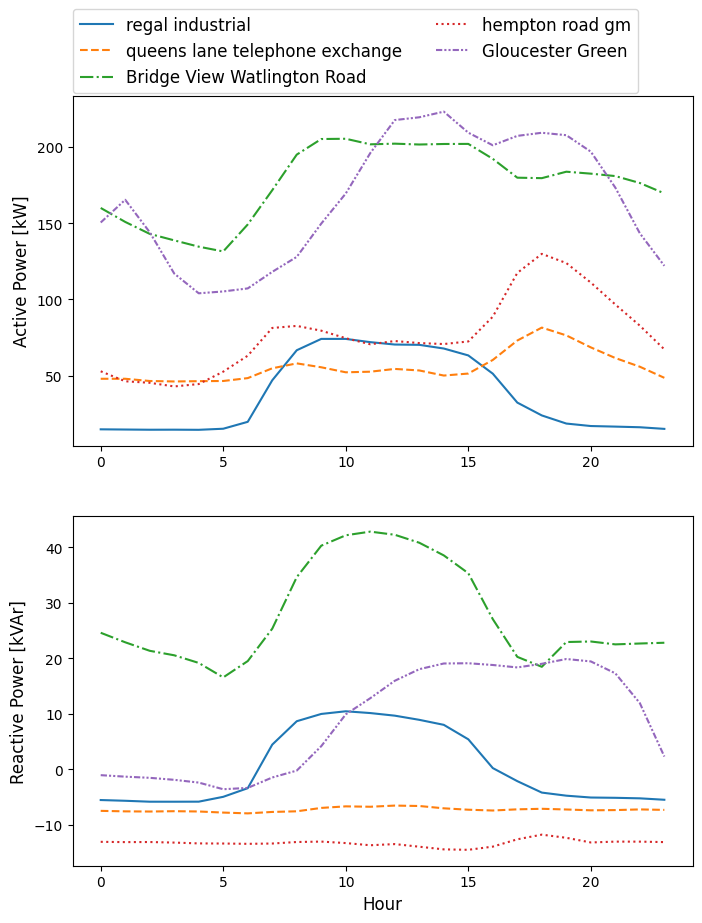

In [54]:
import matplotlib.pyplot as plt
import random
# random.seed(10)
# random_substations = random.sample(list(dataframes.keys()), 5)

# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# # Plot the active power from the 5 substations on a specific day
# for substation in random_substations:
#     ax1.plot(dataframes[substation].groupby('Hour').mean()['Active Power [kW]'], label=substation)
# ax1.set_ylabel("Active Power [kW]")
# ax1.set_xlabel("Hour")

# # Plot the reactive power from the 5 substations on a specific day
# for substation in random_substations:
#     ax2.plot(dataframes[substation].groupby('Hour').mean()['Reactive Power [kVAr]'], label=substation)
# ax2.set_ylabel("Reactive Power [kVAr]")
# ax2.set_xlabel("Hour")

# # Legend for the figure
# plt.legend(random_substations, loc='upper right', bbox_to_anchor=(1.6, 1))
# # Save and show the figure
# plt.tight_layout()
# plt.savefig("figures/report/five_rep_ss_power.png")
# # plt.show()


random.seed(10)
random_substations = random.sample(list(dataframes.keys()), 5)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8,10))

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
# Plot the active power from the 5 substations on a specific day
handles = []
labels = []
for idx, substation in enumerate(random_substations):
    dataframes[substation]['Hour'] = dataframes[substation]['Datetime'].dt.hour
    line, = ax1.plot(dataframes[substation].groupby('Hour').mean()['Active Power [kW]'], label=substation, linestyle = linestyles[idx])
    handles.append(line)
    labels.append(substation)

ax1.set_ylabel("Active Power [kW]", fontsize = 12)
#ax1.set_xlabel("Hour"m)

# Plot the reactive power from the 5 substations on a specific day
for idx,substation in enumerate(random_substations):
    print(substation)
    line, = ax2.plot(dataframes[substation].groupby('Hour').mean()['Reactive Power [kVAr]'], label=substation, linestyle =linestyles[idx])

ax2.set_ylabel("Reactive Power [kVAr]", fontsize = 12)
ax2.set_xlabel("Hour", fontsize = 12)

# Create a single legend for the entire figure
fig.legend(handles, labels, loc = 'upper left', bbox_to_anchor = (0.115, 0.975), fontsize = 12, ncol = 2)

# Save and show the figure
#plt.tight_layout()
plt.savefig("figures/report/five_rep_ss_power.png", bbox_inches = "tight")
plt.show()


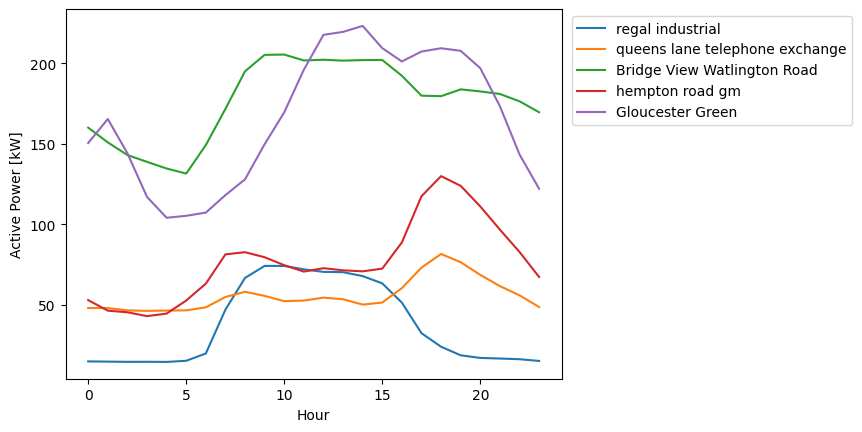

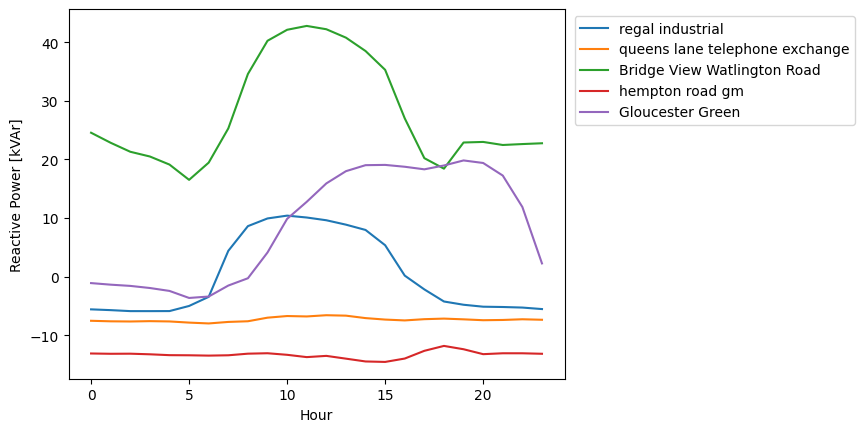

In [121]:
# Plot the active and reactive power for 5 different substations on a specific day
import random 
# Choose 5 random substations from dataframes.keys

random.seed(10)
random_substations = random.sample(list(dataframes.keys()), 5)

# Plot the active power from the 5 substations on a specific day
for substation in random_substations:
    plt.plot(dataframes[substation].groupby('Hour').mean()['Active Power [kW]'], label = substation)
plt.legend(random_substations, loc= 'upper right', bbox_to_anchor=(1.6, 1))
plt.ylabel("Active Power [kW]")
plt.xlabel("Hour")
plt.savefig("figures/report/five_rep_ss_active_power.png")
plt.show()

# Plot the reactive power from the 5 substations on a specific day
for substation in random_substations:
    plt.plot(dataframes[substation].groupby('Hour').mean()['Reactive Power [kVAr]'], label = substation)
plt.legend(random_substations, loc = 'upper right', bbox_to_anchor=(1.6, 1))
plt.ylabel("Reactive Power [kVAr]")
plt.xlabel("Hour")
plt.savefig("figures/report/five_rep_ss_reactive_power.png")
plt.show()

### <font color = 'lightgreen'> Single plot showing missing values and outliers <font>

In [ ]:
# folder_path = "../Substation Busbar Data/"
# raw_dataframes, id_s = substation_analysis_functions.read_substation_data(folder_path)
active_upper_threshold = 700
active_lower_threshold = 0

reactive_upper_threshold = 250
reactive_lower_threshold = -100

for substation in raw_dataframes:
    plt.plot(raw_dataframes[substation]['Active Power [kW]'])
# draw horizontal lines at upper and lower thresholds
plt.axhline(y=active_upper_threshold, color='black', linestyle = 'dashed')
plt.axhline(y=active_lower_threshold, color='black', linestyle='dashed')
plt.xlabel("Hour")
plt.ylabel('Active Power [kW]')
plt.savefig("figures/report/active_power_outliers.png")
plt.show()

for substation in raw_dataframes:
    plt.plot(raw_dataframes[substation]['Reactive Power [kVAr]'])
    
plt.axhline(y=reactive_upper_threshold, color='black', linestyle='dashed')
plt.axhline(y=reactive_lower_threshold, color='black', linestyle='dashed')
plt.xlabel("Hour")
plt.ylabel('Reactive Power [kVar]')
plt.savefig("figures/report/reactive_power_outliers.png")
plt.show()

### <font color = 'lightgreen'> Two Histogram plots of peak demand for a specific season on working days and weekends for two substations <font>

In [25]:
folder_path = "../Substation Busbar Data/"
dataframes, id_s = substation_analysis_functions.read_substation_data(folder_path)

######################################################################################################
#################################### Data Cleaning ##############################################
######################################################################################################


##### Data Cleaning: Handle missing Vals and bad power vals ######

dataframes = substation_analysis_functions.handle_missing_vals(dataframes, threshold = 0.5)
for substation, df in dataframes.items():
    dataframes[substation] = substation_analysis_functions.detect_bad_power_vals(df,active_upper_threshold = 700, active_lower_threshold = 0, reactive_upper_threshold = 250, reactive_lower_threshold = -100)   
    
##### Data Transformation: Split dataset by season ######

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = substation_analysis_functions.split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}
    
    
chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = substation_analysis_functions.split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        
##### Data Cleaning; Drop substations that don't have enough data in a time-of-week/season combo ######

chopped_substation_dfs = substation_analysis_functions.drop_underful_substations(chopped_substation_dfs)

Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000

/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Datetime'].dt.weekday


Substation Mill St flats has only 12 days of data in fall weekend (<~1/2 of what should be there). Dropping from analysis.
Substation Gloucester Green has only 22 days of data in winter week (<~1/2 of what should be there). Dropping from analysis.
Substation Gloucester Green has only 9 days of data in winter weekend (<~1/2 of what should be there). Dropping from analysis.
Substation Hockmore Street has only 23 days of data in summer week (<~1/2 of what should be there). Dropping from analysis.
Substation Hockmore Street has only 9 days of data in summer weekend (<~1/2 of what should be there). Dropping from analysis.
Substation woodcroft has only 23 days of data in summer week (<~1/2 of what should be there). Dropping from analysis.
Substation woodcroft has only 9 days of data in summer weekend (<~1/2 of what should be there). Dropping from analysis.
Substation kennington church (cow lane) has only 0 days of data in spring week (<~1/2 of what should be there). Dropping from analysis.
S

In [67]:
# Let's do summer!
ss_1 = 'regal industrial'
ss_2 = 'Gloucester Green'
szn = 'summer'

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_25009/2289546351.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substation_data['Date'] = substation_data['Datetime'].dt.date
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_25009/2289546351.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substation_data['Hour'] = substation_data['Datetime'].dt.hour
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_25009/2289546351.py:30: FutureWarning: 

`shade` is now deprecated in f

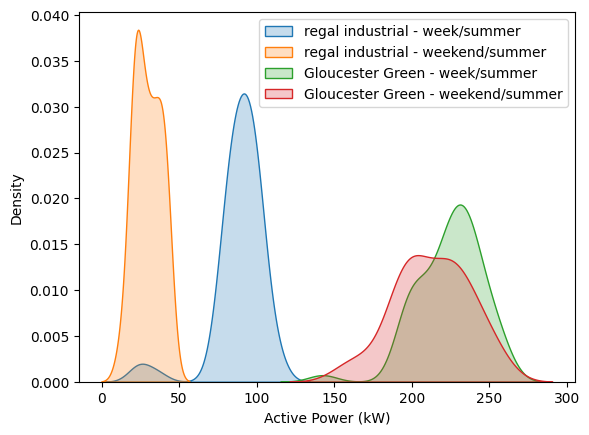

In [115]:
# Find all peak active hours for each substation and plot a histogram of the peak active hours
chopped_substation_dfs[ss_1][szn]['week']
chopped_substation_dfs[ss_1][szn]['weekend']

chopped_substation_dfs[ss_2][szn]['week']
chopped_substation_dfs[ss_2][szn]['weekend']
active = True
import seaborn as sns
for ss in [ss_1, ss_2]:
    for time_of_week in ['week', 'weekend']:
        substation_data = chopped_substation_dfs[ss][szn][time_of_week]
        
        substation_data['Date'] = substation_data['Datetime'].dt.date
        substation_data['Hour'] = substation_data['Datetime'].dt.hour

        # Group the data by date
        daily_groups = substation_data.groupby(['Date'])
        
        
        # Plot a density plot of the peak active power for each day
      # Create a list to store the peak active power values for each day
        peak_power_values = []
        
        # Iterate over each group of data and calculate the peak active power value for that day
        for date, group in daily_groups:
            peak_power = group['Active Power [kW]'].max()
            peak_power_values.append(peak_power)
        
        # Create a density plot of the peak active power values for each day
        sns.kdeplot(peak_power_values, shade=True, label=f'{ss} - {time_of_week}/{szn}')
        plt.legend()
        
plt.xlabel("Active Power (kW)",fontsize = 12)
plt.ylabel("Density", fontsize = 12)        
plt.savefig("figures/report/peak_active_pwr_density.png")
plt.show()


    # # Find the hour of peak Active Power for each date 
    #     peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    #                 # Count the number of times each hour appears as the peak hour for each day
    #     peak_counts = peak_hour.value_counts()
        
    #     plt.bar(peak_counts.index, peak_counts.values)
    #     # change x lims to be from 0 to 23 for the bar chart
    #     plt.xlim(0, 23)
    #     plt.xlabel('Hour of the day')
    #     plt.ylabel('Density')
    #     plt.title(f'Peak Active Power Distribution for {ss} {time_of_week} {szn}')
    #   #  plt.savefig(f'figures/report/peak_hr_hist_{ss}_{time_of_week}_{szn}.png')
    #     plt.show()
            
        # else:
        #         # Find the hour of peak positive and negative Reactive power for each day
        #     peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
        #     peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
            
        #         # Count the number of times each hour appears as the peak hour for each day
        #     peak_counts_max = peak_hour_max.value_counts()
        #     peak_counts_min = peak_hour_min.value_counts()
            
        #     plt.bar(peak_counts_max.index, peak_counts_max.values)
        #     plt.xlabel('Hour of the day')
        #     plt.ylabel('Frequency of being peak hour')
        #     plt.title(f'Positive Reactive Power Peak Hour Distribution for {ss}')
        #     plt.show()
        #     plt.bar(peak_counts_min.index, peak_counts_min.values)
        #     plt.xlabel('Hour of the day')
        #     plt.ylabel('Frequency of being peak hour')
        #     plt.title(f'Negative Reactive Power Peak Hour Distribution for {ss}')
            # plt.show()

### <font color = 'lightgreen'> Plot to show how the pattern of Active Power for a substation is different for different seasons <font>

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_90510/2226867194.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substation_dataframes[substation][season]['Hour'] = substation_dataframes[substation][season]['Datetime'].dt.hour


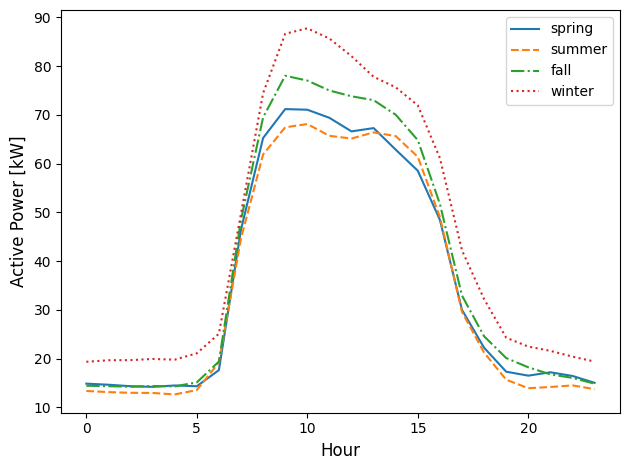

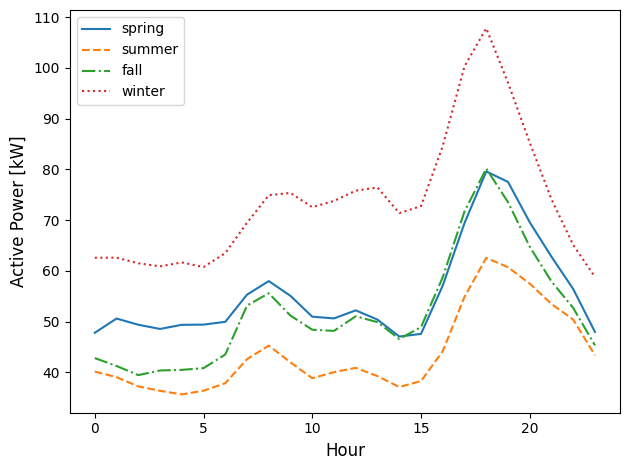

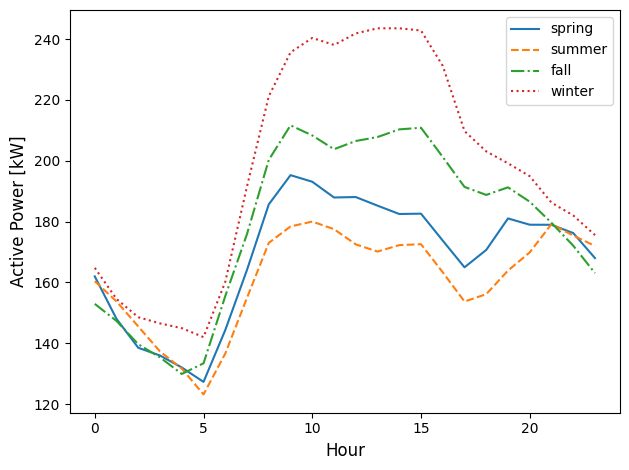

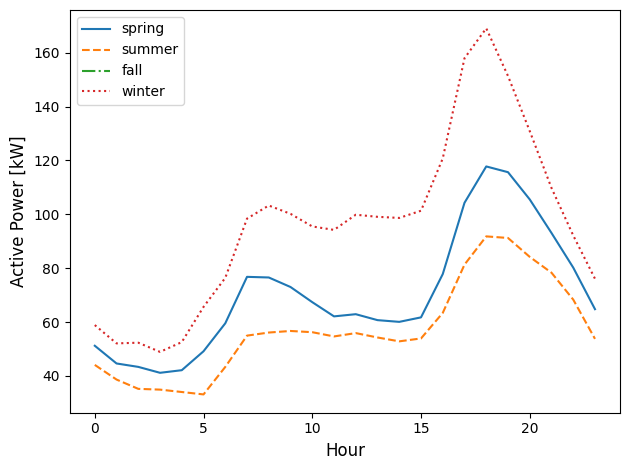

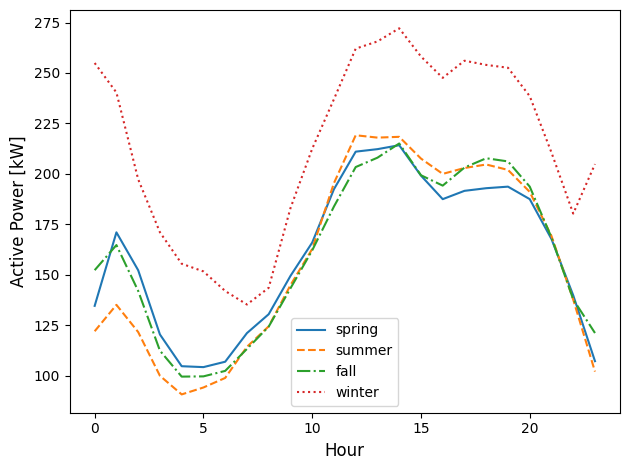

In [48]:

# plt.plot(substation_dataframes[substation]['spring']['Active Power [kW]'], color = 'green', label = 'spring')
# plt.plot(substation_dataframes[substation]['summer']['Active Power [kW]'], color = 'yellow', label = 'summer', alpha = 0.5)
# plt.plot(substation_dataframes[substation]['fall']['Active Power [kW]'], color = 'red', label = 'fall', alpha = 0.8)
# plt.plot(substation_dataframes[substation]['winter']['Active Power [kW]'], color = 'blue', label = 'winter', alpha = 0.7)
# plt.legend()
# plt.xlabel("Hour")
# plt.ylabel("Active Power [kW]")
# plt.title("Gloucester Green Active Power by Season")
# plt.savefig("figures/report/gloucester_green_ap_by_szn.png")
# plt.show()


# Plot the active power from a specific substation for each season 
linestyles = ['-', '--', '-.', ':']
colors = ['green', 'orange', 'red', 'blue', 'black']
for idx, substation in enumerate(random_substations):
    for season_idx,season in enumerate(substation_dataframes[substation]):
        substation_dataframes[substation][season]['Hour'] = substation_dataframes[substation][season]['Datetime'].dt.hour
        plt.plot(substation_dataframes[substation][season].groupby('Hour').mean()['Active Power [kW]'], label = season, linestyle = linestyles[season_idx])
    plt.ylabel("Active Power [kW]", fontsize = 12)
    plt.xlabel("Hour", fontsize = 12)
    # if substation == 'queens lane telephone exchange':
    #     plt.title("Queens Lane Telephone Exchange Active Power by Season")
    # else:
    #     plt.title(f"{substation} Active Power by Season")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/report/{substation} Active Power by Season")
    plt.show()

Phase  Feeder  Active Power [kW]  Reactive Power [kVAr]  \
0      All  Busbar         194.012857               2.523571   
1      All  Busbar         197.645000               3.066500   
2      All  Busbar         204.960500               5.800000   
3      All  Busbar         184.980000               4.932500   
4      All  Busbar         172.137000               3.408000   
...    ...     ...                ...                    ...   
1221   All  Busbar         175.312000              23.384000   
1222   All  Busbar         174.509500              24.498000   
1223   All  Busbar         155.240500              20.599000   
1224   All  Busbar         142.295000              15.561500   
1225   All  Busbar         119.178000               9.508500   

      Apparent Power [kVA]  Power Factor            Datetime  Month  
0               194.045689     -0.571266 2022-04-10 12:00:00      4  
1               197.683037     -0.899807 2022-04-10 13:00:00      4  
2               205.054031     -0.999548 2022-04-10 14:00:00      4  
3               185.057924     -0.999579 2022-04-10 15:00:00      4  
4               172.185576     -0.799727 2022-04-10 16:00:00      4  
...                    ...           ...                 ...    ...  
1221            176.884337     -0.991067 2022-05-31 19:00:00      5  
1222            176.243114     -0.990188 2022-05-31 20:00:00      5  
1223            156.627617     -0.991110 2022-05-31 21:00:00      5  
1224            143.161321     -0.993915 2022-05-31 22:00:00      5  
1225            119.700122     -0.595879 2022-05-31 23:00:00      5  

[1202 rows x 8 columns]

### <font color = 'lightgreen'> Heatmap (corr matrix) of 5 features of active power for a substation (use Elnaz' features) <font>

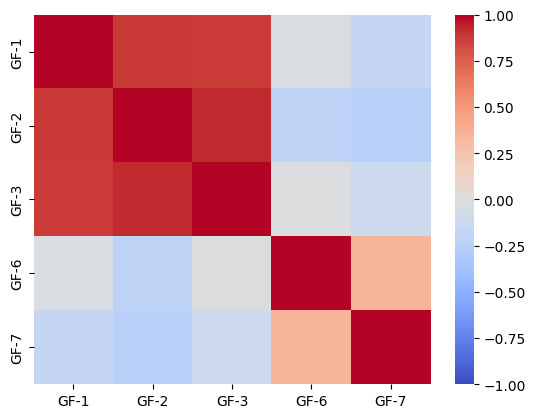

In [28]:
import seaborn as sns
substation = random_substations[1]
df = dataframes[substation]
df['Date'] = df['Datetime'].dt.date

# Gather 5 active power features for the substation
labels = ['GF-1', 'GF-2', 'GF-3', 'GF-6', 'GF-7']

# Total Daily Active Power
total_daily_active_power = df.groupby('Date').sum()['Active Power [kW]']
# Mean Daily Active Power
mean_daily_active_power = df.groupby('Date').mean()['Active Power [kW]']
# Peak Daily Active Power
peak_daily_active_power = df.groupby('Date').max()['Active Power [kW]']
df.set_index('Date')

# Number of hours above 1.25 * mean and below 0.75 * mean per day
mean_powers = df.groupby('Date')['Active Power [kW]'].mean().reset_index()
mean_powers.columns = ['Date', 'Mean Active Power [kW]']
df = df.merge(mean_powers, on='Date', how='left')
df['Active Power Above 1.25 * Mean'] = np.where(df['Active Power [kW]'] > df['Mean Active Power [kW]'] * 1.25, 1, 0)
df['Active Power Below 0.75 * Mean'] = np.where(df['Active Power [kW]'] < df['Mean Active Power [kW]'] * 0.75, 1, 0)
# above 1.25 * mean
hours_above_125pct_mean = df.groupby('Date').sum()['Active Power Above 1.25 * Mean']
# below 0.75 * mean
hours_below_075pct_mean = df.groupby('Date').sum()['Active Power Below 0.75 * Mean']


# Create corr matrix of active power features
corr_matrix = pd.concat([total_daily_active_power, mean_daily_active_power, peak_daily_active_power, hours_above_125pct_mean, hours_below_075pct_mean], axis=1).corr()

# Create a heatmap of the correlation matrix with seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', xticklabels = labels, yticklabels = labels, vmin = -1, vmax = 1, center = 0)

#plt.title("Active Power [kW] Features for Queens Lane Telephone Exchange")
#plt.suptitle(f"Queens Lane Telephone Exchange")
plt.savefig(f'figures/report/ap_corr_heatmap_{substation}.png')
#plt.tight_layout()
plt.show()


In [232]:
substation = random_substations[0]
df = dataframes[substation]


Date
2022-04-10     2
2022-04-11    10
2022-04-12    10
2022-04-13    10
2022-04-14    10
              ..
2022-12-28     9
2022-12-29    10
2022-12-30     9
2022-12-31     8
2023-01-01     0
Name: Active Power Above Mean, Length: 267, dtype: int64

In [ ]:
total_daily_active_power, total_daily_active_power_2

NameError: name 'total_daily_active_power_2' is not defined

### <font color = 'lightgreen'> For a few substations with lots of missing data, show its active power signal over the year <font>

In [29]:
low_data_substations = []
for substation in dataframes:
    # number of hours in a year
    num_hrs_yr = 8760
    if (len(dataframes[substation]) < num_hrs_yr/2) & (len(dataframes[substation]) > 2000):
        print(substation, len(dataframes[substation]))
        low_data_substations.append(substation)


Springfield Road 3352
blue boar quad RMU3 3640
Rivermead Road SS 3686
hempton road gm 3056
Little more hospital 3444
Chilton Garden Centre 3689
littlemore pk 3684


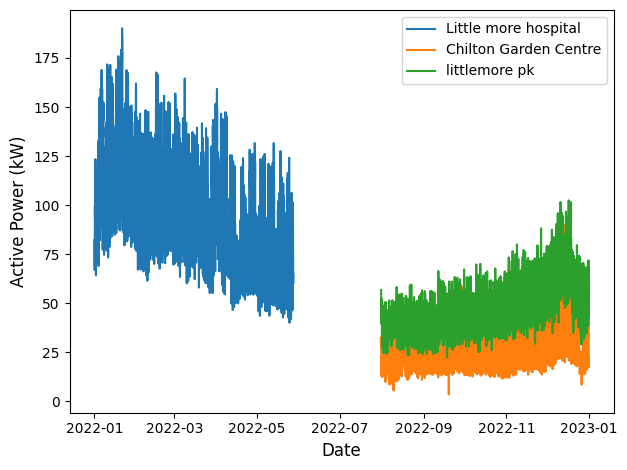

In [32]:
#take the back half of low_data_substations
for substation in low_data_substations[4:]:    
    ss_with_low_data = dataframes[substation]
    plt.plot(ss_with_low_data['Datetime'], ss_with_low_data['Active Power [kW]'], label = substation) 
    
#plt.title("Yearly Active Power [kW] signal for Substations with Missing Data")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Active Power (kW)",fontsize = 12)
plt.legend()
plt.tight_layout()
plt.savefig("figures/report/yearly_ap_for_substations_with_missing_data.png")
plt.show()


# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Convert the start and end dates to numerical values
# start_date = pd.to_datetime('2022-01-01')
# end_date = pd.to_datetime('2023-01-01')

# # Plot the data
# plt.plot(ss_with_low_data['Datetime'], ss_with_low_data['Active Power [kW]'], label=substation)

# # Set the x-axis limits
# plt.xlim(start_date, end_date)

# # Format the x-axis labels
# # Add a legend and show the plot
# plt.legend()
# plt.show()


### <font color = 'lightgreen'> Plot peak hour bins for a specific substation <font>

In [40]:
chopped_substation_dfs[substation]

{'spring': {'week':      Phase  Feeder  Active Power [kW]  Reactive Power [kVAr]  \
  10     All  Busbar            15.7695                -5.4905   
  11     All  Busbar            15.0190                -5.8060   
  12     All  Busbar            15.7165                -6.0140   
  13     All  Busbar            15.0400                -6.0135   
  14     All  Busbar            16.0090                -5.8470   
  ...    ...     ...                ...                    ...   
  1229   All  Busbar            13.5985                -6.0740   
  1230   All  Busbar            12.8165                -5.9850   
  1231   All  Busbar            14.7100                -6.1585   
  1232   All  Busbar            14.6880                -5.7840   
  1233   All  Busbar            13.2370                -6.2655   
  
        Apparent Power [kVA]  Power Factor            Datetime  Month  weekday  
  10               16.750989      0.939887 2022-04-11 00:00:00      4        0  
  11               16.136

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_90510/3834999095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substation_data['Date'] = substation_data['Datetime'].dt.date
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_90510/3834999095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substation_data['Hour'] = substation_data['Datetime'].dt.hour


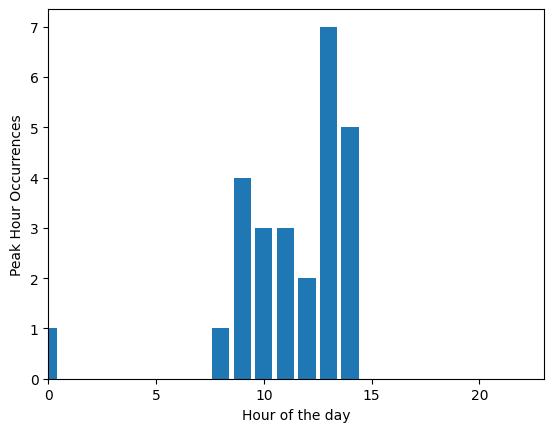

In [44]:
substation = 'regal industrial'
substation_data = chopped_substation_dfs[substation]['summer']['weekend']
substation_data['Date'] = substation_data['Datetime'].dt.date
substation_data['Hour'] = substation_data['Datetime'].dt.hour
daily_groups = substation_data.groupby(['Date'])
# Find the hour of peak Active Power for each date 
peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            # Count the number of times each hour appears as the peak hour for each day
peak_counts = peak_hour.value_counts()

plt.bar(peak_counts.index, peak_counts.values)
plt.xlabel('Hour of the day')
plt.ylabel('Peak Hour Occurrences')
plt.xlim(0, 23)
#plt.title(f'Peak Hour Distribution for {substation}')
plt.savefig(f'figures/report/peak_hour_distribution_{substation}.png', bbox_inches = "tight")
plt.show()